In [1]:
import os
import sys
sys.path.append("..")
import numpy as np
from py_helpers.general_helpers import *

# Define the paths to the results
labs = False
if labs:
    results_path = "/media/hsa22/Expansion/WBM/results"
else:
    results_path = "D:\\WBM\\results"

## **Load the Data**

In [2]:
# Function to return a dictionary of the files organized
def organize_files(txt_files, csv_files, name="model"):

    # Dictionary to store the files
    organized_files = {}

    # Loop through the files and add them to the dictionary
    for file in txt_files:
        # Depending on name, add it to the dictionary
        if name in file:
            # Get whether it's symmetric or not
            symmetric = file.split(os.sep)[-3]
            # Define the corresponding csv as the path up until -1
            corresponding_csv = os.path.join((os.sep).join(file.split(os.sep)[:-1]), "sim_FC.csv")
            # If the csv exists, add it to the dictionary
            if corresponding_csv in csv_files:
                data_dict = {
                    "txt_path": file,
                    "csv_path": corresponding_csv,
                    "correlation": np.loadtxt(file),
                    "sim_FC": np.genfromtxt(corresponding_csv, delimiter=",")
                }
                
                # Append the data dictionary to the organized_files under symmetric key
                if symmetric in organized_files:
                    organized_files[symmetric].append(data_dict)
                else:
                    organized_files[symmetric] = [data_dict]

    # Return the dictionary
    return organized_files

In [3]:
# Grab all the txt and csv files for the correlation
txt_files = glob_files(results_path, "txt")
csv_files = glob_files(results_path, "csv")

# Assert that the number of txt and csv files are the same
assert len(txt_files) == len(csv_files), "Number of txt and csv files are not the same!"

# Define dictionary for model, traditional, and tracer files
model_files = organize_files(txt_files, csv_files, name="model")
trad_files = organize_files(txt_files, csv_files, name="traditional")
tracer_files = organize_files(txt_files, csv_files, name="tracer")

# Print the length of each dictionary - or the number of items for both symmetric and asymmetric
# print("Number of symmetric model files: {}".format(len(model_files["symmetric"])))
print("Number of asymmetric model files: {}".format(len(model_files["asymmetric"])))
# print("Number of symmetric traditional files: {}".format(len(trad_files["symmetric"])))
print("Number of asymmetric traditional files: {}".format(len(trad_files["asymmetric"])))
print("Number of symmetric tracer files: {}".format(len(tracer_files["symmetric"])))
print("Number of asymmetric tracer files: {}".format(len(tracer_files["asymmetric"])))

Number of asymmetric model files: 298
Number of asymmetric traditional files: 303
Number of symmetric tracer files: 251
Number of asymmetric tracer files: 302


## **Organize Data into Pandas Dataframe**

In [4]:
import pandas as pd
import re

# Function to organize data into pandas dataframe
def extract_data_and_create_df(entries):
    """Utility function to extract data and create a dataframe."""
    df_rows = []
    for entry in entries:
        # Extract the coupling and delay values using regex
        match = re.search(r"Coupling (\d+\.\d+), Delay(\d+\.\d+)", entry["txt_path"])

        if match:
            coupling, delay = float(match.group(1)), float(match.group(2))
            df_rows.append(((coupling, delay), entry["correlation"]))

    return pd.DataFrame(df_rows, columns=["(Coupling, Delay)", "Correlation"])

In [5]:
import pandas as pd
import re

# Create a dataframe for the model, traditional, and tracer
model_asym_df = extract_data_and_create_df(model_files["asymmetric"])
trad_asym_df = extract_data_and_create_df(trad_files["asymmetric"])
tracer_asym_df = extract_data_and_create_df(tracer_files["asymmetric"])

# Print the length of each dataframe
print("Number of asymmetric model dataframes: {}".format(len(model_asym_df)))
print("Number of asymmetric traditional dataframes: {}".format(len(trad_asym_df)))
print("Number of asymmetric tracer dataframes: {}".format(len(tracer_asym_df)))

Number of asymmetric model dataframes: 298
Number of asymmetric traditional dataframes: 303
Number of asymmetric tracer dataframes: 302


## **Plot the Data**

In [6]:
import seaborn as sns

# Generate a cubehelix color palette with more contrast
color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.1, light=0.9)
pinkish = color_palette[2]
purpleish = color_palette[6]
inbetween = color_palette[4]

beige_palette = sns.light_palette(color_palette[4], n_colors=10)
beige_color = beige_palette[1]
custom_colorscale = [
    [0, 'rgb'+str(pinkish)],
    [0.5, 'rgb'+str(beige_color)],
    [1, 'rgb'+str(purpleish)]
]

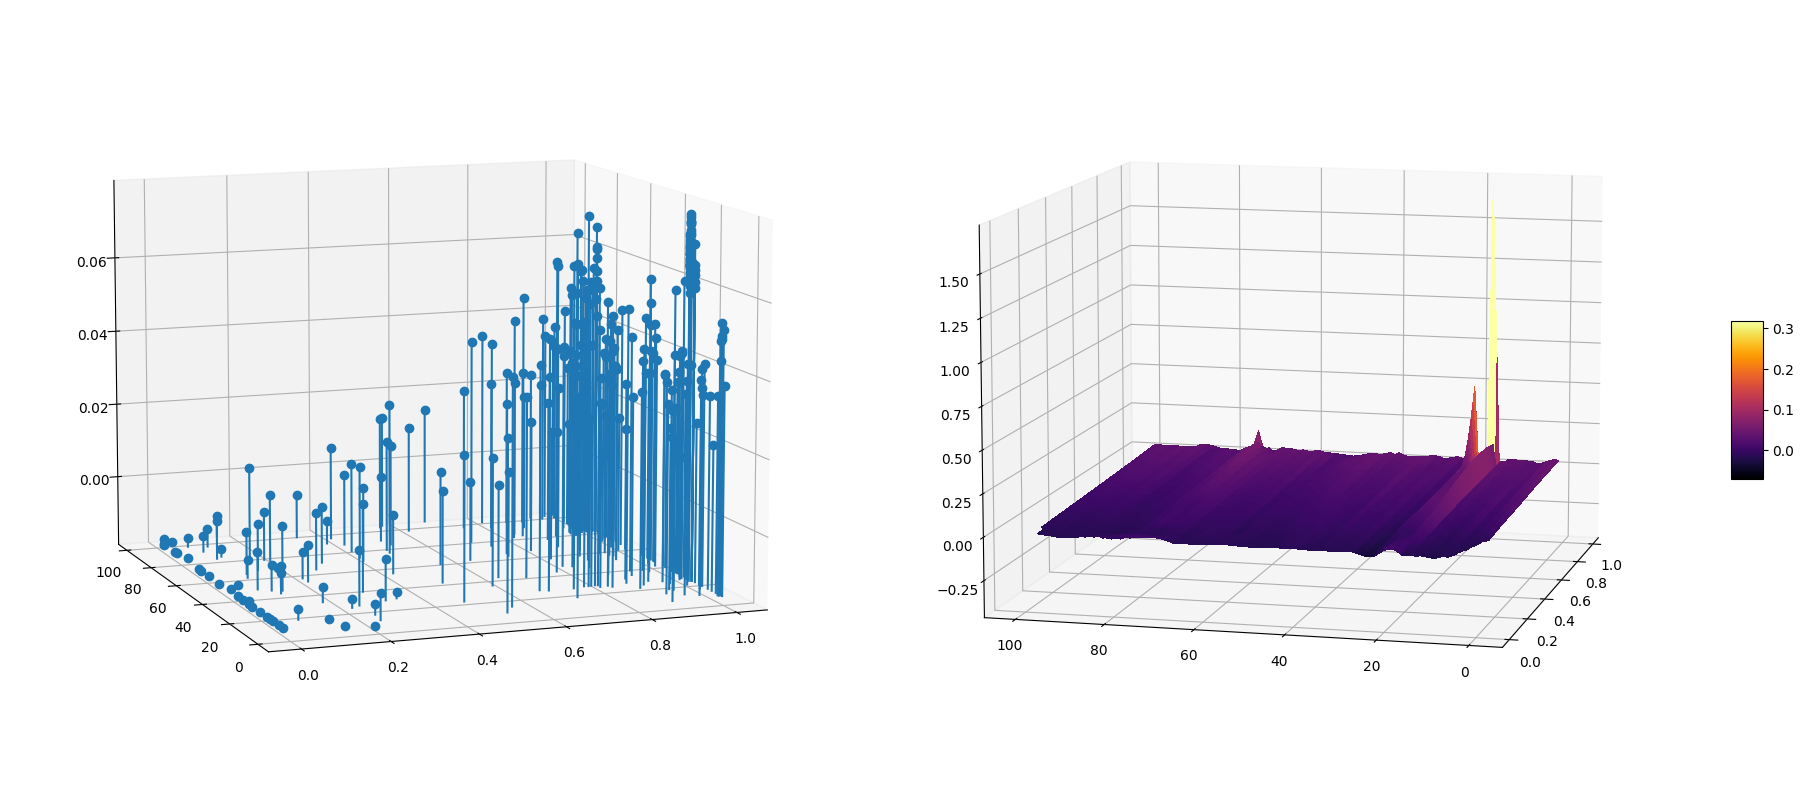

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib widget

# Function to create the plotly meshgrid heatmap
def plot_meshgrid(df, title):
    # Extracting data from dataframe
    coupling = df['(Coupling, Delay)'].apply(lambda x: x[0]).values
    delay = df['(Coupling, Delay)'].apply(lambda x: x[1]).values
    correlation = df['Correlation'].values
    
    # Extracting the number of iterations by the length of the coupling
    num_iterations = len(coupling)

     # Define the figure and first axis
    # fig = plt.figure(figsize=plt.figaspect(0.5))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8), subplot_kw=dict(projection='3d'), constrained_layout=True)
    # Define the min, max of the data
    xi = np.linspace(coupling.min(),coupling.max(),100)
    yi = np.linspace(delay.min(),delay.max(),100)
    # VERY IMPORTANT, to tell matplotlib how is your data organized
    zi = griddata((coupling, delay), correlation, (xi[None,:], yi[:,None]), method='cubic')
    # Define the stem object
    ax1.stem(coupling, delay, correlation, bottom=correlation.min(), basefmt=" ", orientation='z')
    ax1.view_init(elev=10, azim=-110)

    # Create a meshgrid
    xig, yig = np.meshgrid(xi, yi)
    # Define the surface object to plot
    surf = ax2.plot_surface(xig, yig, zi, linewidth=0, cmap='inferno', antialiased=False)
    # Add a color bar to the plot
    fig.colorbar(surf, shrink=0.2, aspect=5)
    ax2.view_init(elev=10, azim=-166)

    # # Give the figure a title
    # fig.suptitle('{} BO Values after {} Steps'.format(model_name, steps))
    # # Set the labels of the figure
    # ax1.set_xlabel('{}'.format(xlabel))
    # ax2.set_xlabel('{}'.format(xlabel))
    # ax1.set_ylabel('{}'.format(ylabel))
    # ax2.set_ylabel('{}'.format(ylabel))
    # ax1.set_zlabel('{}'.format(zlabel), labelpad=7)
    # ax2.set_zlabel('{}'.format(zlabel))
    # Set aspects
    ax1.set_aspect('auto')
    ax2.set_aspect('auto')
    
    # Show the plot
    plt.show()

plot_meshgrid(model_asym_df, "Model")
